命名实体识别（Named Entity Recognition，简称NER），又称作“专名识别”，是指识别文本中具有特定意义的实体，主要包括人名、地名、机构名、专有名词等。

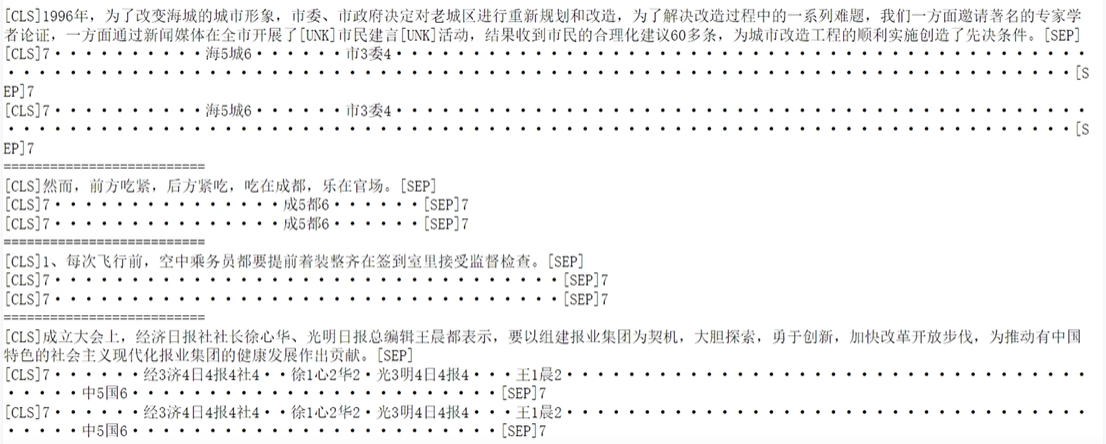

In [3]:
from transformers import AutoTokenizer

# 加载分词器
# hf l , 不是1.
tokenizer = AutoTokenizer.from_pretrained('hfl/rbt6')
print(tokenizer)

BertTokenizerFast(name_or_path='hfl/rbt6', vocab_size=21128, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [5]:
tokenizer.batch_encode_plus([[
    '海', '钓', '比', '赛', '地', '点', '在', '厦', '门', '与', '金', '门', '之', '间',
        '的', '海', '域', '。'
],
    [ '这', '座', '依', '山', '傍', '水', '的', '博', '物', '馆', '由', '国', '内', '一',
         '流', '的', '设', '计', '师', '主', '持', '设', '计', '，', '整', '个', '建', '筑',
         '群', '精', '美', '而', '恢', '宏', '。']],
truncation=True,
padding=True,
return_tensors='pt',
is_split_into_words=True)

{'input_ids': tensor([[ 101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305,  680, 7032,
         7305,  722, 7313, 4638, 3862, 1818,  511,  102,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [ 101, 6821, 2429,  898, 2255,  988, 3717, 4638, 1300, 4289, 7667, 4507,
         1744, 1079,  671, 3837, 4638, 6392, 6369, 2360,  712, 2898, 6392, 6369,
         8024, 3146,  702, 2456, 5029, 5408, 5125, 5401, 5445, 2612, 2131,  511,
          102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [6]:
from datasets import load_from_disk

In [8]:
dataset = load_from_disk('../data/peoples_daily_ner')
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4637
    })
})

In [10]:
dataset['train'][0]

{'id': '0',
 'tokens': ['海',
  '钓',
  '比',
  '赛',
  '地',
  '点',
  '在',
  '厦',
  '门',
  '与',
  '金',
  '门',
  '之',
  '间',
  '的',
  '海',
  '域',
  '。'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0]}

In [9]:
import torch

In [11]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, split):
        # names [ '0', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']
        dataset = load_from_disk('../data/peoples_daily_ner')[split]
        # 过滤掉太长的句子
        def f(data):
            return len(data['tokens']) <= 512 - 2
        
        dataset = dataset.filter(f)
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        tokens = self.dataset[i]['tokens']
        labels = self.dataset[i]['ner_tags']
        return tokens, labels

In [12]:
dataset = Dataset('train')
tokens, labels = dataset[0]
len(dataset), tokens, labels

Loading cached processed dataset at D:\AIoT-深度学习视频版\深度学习基础\自然语言处理\NLP入门\data\peoples_daily_ner\train\cache-83ad87bb87c51358.arrow


(20852,
 ['海',
  '钓',
  '比',
  '赛',
  '地',
  '点',
  '在',
  '厦',
  '门',
  '与',
  '金',
  '门',
  '之',
  '间',
  '的',
  '海',
  '域',
  '。'],
 [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0])

In [15]:
def collate_fn(data):
    tokens = [i[0] for i in data]
    labels = [i[1] for i in data]
    inputs = tokenizer.batch_encode_plus(tokens, 
                                        truncation=True,
                                        padding=True,
                                        return_tensors='pt',
                                        is_split_into_words=True)
    lens = inputs['input_ids'].shape[1]
    
    for i in range(len(labels)):
        labels[i] = [7] + labels[i]
        labels[i] += [7] * lens
        labels[i] = labels[i][:lens]
    return inputs, torch.LongTensor(labels)



In [16]:
# 数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset,
                                    batch_size=16,
                                    collate_fn=collate_fn,
                                    shuffle=True,
                                    drop_last=True)

for (inputs, labels) in loader:
    break

In [17]:
len(loader)

1303

In [21]:
tokenizer.decode(inputs['input_ids'][0])

'[CLS] 他 们 傲 慢 地 声 称 ： 『 我 们 的 生 产 技 术 是 国 际 一 流 的 ， 加 工 水 平 是 世 界 上 最 先 进 的 ， 产 品 绝 对 不 会 出 现 任 何 问 题 。 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [22]:
labels[0]

tensor([7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [23]:
for k, v in inputs.items():
    print(k, v.shape)

input_ids torch.Size([16, 86])
token_type_ids torch.Size([16, 86])
attention_mask torch.Size([16, 86])


In [84]:
# 加载预训练模型
from transformers import AutoModel

pretrained = AutoModel.from_pretrained('hfl/rbt6').to(device)

print(sum(i.numel() for i in pretrained.parameters()))

Some weights of the model checkpoint at hfl/rbt6 were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


59740416


In [25]:
pretrained(**inputs).last_hidden_state.shape

torch.Size([16, 86, 768])

In [76]:
# 定义下游任务模型
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.tuneing = False
        self.pretrained = None
        
        self.rnn = torch.nn.GRU(768, 768, batch_first=True)
        self.fc = torch.nn.Linear(768, 8)
        
    def forward(self, input_ids, token_type_ids, attention_mask):
        if self.tuneing:
            out = self.pretrained(input_ids, token_type_ids, attention_mask).last_hidden_state
        else:
            out = pretrained(input_ids, token_type_ids, attention_mask).last_hidden_state
            
        out, _ = self.rnn(out)
        out = self.fc(out).softmax(dim=2)
        return out
    
    def fine_tuneing(self, tuneing):
        self.tuneing = tuneing
        if tuneing:
            for i in pretrained.parameters():
                i.requires_grad = True
                
            pretrained.train()
            self.pretrained = pretrained
        else:
            for i in pretrained.parameters():
                i.requires_grad_(False)
            pretrained.eval()
            self.pretrained = None
            
            

In [77]:
model = Model()

In [78]:
model(**inputs).shape

torch.Size([16, 86, 8])

In [31]:
labels.shape

torch.Size([16, 86])

In [35]:
inputs['attention_mask'].shape

torch.Size([16, 86])

In [34]:
inputs['attention_mask']

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [36]:
# 对结果和label进行变形, 移除pad
def reshape_and_remove_pad(outs, labels, attention_mask):
    # [batch, lens, 8] -> [batch * lens, 8]
    outs = outs.reshape(-1, 8)
    # [batch, lens] -> [batch * lens]
    labels = labels.reshape(-1)
    
    # 忽略pad对计算影响
    # attention_mask [batch, lens]
    condition = attention_mask.reshape(-1) == 1
    outs = outs[condition]
    labels = labels[condition]
    
    return outs, labels

reshape_and_remove_pad(torch.randn(2, 3, 8), torch.ones(2, 3), torch.ones(2, 3))

(tensor([[-0.3954, -2.0475, -0.4138, -1.2135,  0.7311, -1.9530, -1.1810, -0.4241],
         [-1.4138, -0.6140, -1.0825, -0.0478,  0.6542,  0.7930, -0.4205,  1.3577],
         [ 0.2879, -0.8446, -1.2150, -0.2138,  0.3338, -1.6618,  0.7989,  2.1103],
         [ 0.1951, -2.4724,  0.2160,  1.4213, -0.8427,  1.7165, -0.1597,  2.1683],
         [ 0.6389, -1.1863, -1.0862, -1.4376, -0.2547,  0.0889,  1.0011, -0.3153],
         [ 0.7700, -0.8136,  0.8115,  0.4005,  1.7522,  1.6029, -1.5573,  0.8988]]),
 tensor([1., 1., 1., 1., 1., 1.]))

In [37]:
# 获取正确数量和总数
def get_correct_and_total_count(labels, outs):
    # [b*lens, 8] -> [b*lens]
    outs = outs.argmax(dim=1)
    correct = (outs == labels).sum().item()
    total = len(labels)
    
    select = labels != 0
    
    outs = outs[select]
    labels = labels[select]
    correct_content = (outs == labels).sum().item()
    total_content = len(labels)
    return correct, total, correct_content, total_content


In [50]:
get_correct_and_total_count(torch.ones(16), torch.randn(16, 8))

(1, 16, 1, 16)

In [51]:
from transformers import AdamW

In [52]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [53]:
inputs

{'input_ids': tensor([[ 101,  800,  812,  ...,    0,    0,    0],
        [ 101,  679, 1398,  ...,    0,    0,    0],
        [ 101, 1762,  671,  ...,    0,    0,    0],
        ...,
        [ 101, 1079, 1849,  ...,    0,    0,    0],
        [ 101,  915, 1762,  ...,    0,    0,    0],
        [ 101,  679, 5307,  ...,    0,    0,    0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [87]:
def train(epochs):
    lr = 2e-5 if model.tuneing else 5e-4
    
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    model.to(device)
    model.train()
    for epoch in range(epochs):
        for step, (inputs, labels) in enumerate(loader):
            input_ids, token_type_ids, attention_mask = inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']
            input_ids, token_type_ids, attention_mask = input_ids.to(device), token_type_ids.to(device), attention_mask.to(device)
            labels = labels.to(device)
#             print(input_ids.device, labels.device, attention_mask.device, token_type_ids.device)
            outs = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
            
            
            outs, labels = reshape_and_remove_pad(outs, labels, attention_mask)
            
            # 梯度下降
            loss = criterion(outs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            
            if step % 50 == 0:
                counts = get_correct_and_total_count(labels, outs)
                
                accuracy = counts[0] / counts[1]
                accuracy_content = counts[2] / counts[3]
                
                print(epoch, step, loss.item(), accuracy, accuracy_content)
        torch.save(model, '../data/中文命名实体识别.model')

In [88]:
model = Model()
# 没有做fine tuneing, 只训练下游任务部分的参数
model.fine_tuneing(False)
train(2)

0 0 2.0735361576080322 0.17672413793103448 0.2608695652173913
0 50 1.45952570438385 0.8118421052631579 0.0
0 100 1.3780953884124756 0.8960709759188846 0.16326530612244897
0 150 1.4118682146072388 0.8622291021671826 0.1523809523809524
0 200 1.3974529504776 0.8766066838046273 0.14285714285714285
0 250 1.3893790245056152 0.8846611177170036 0.1415929203539823
0 300 1.3906742334365845 0.8833107191316146 0.1568627450980392
0 350 1.4071489572525024 0.8670520231213873 0.31683168316831684
0 400 1.3817538022994995 0.8922852983988355 0.3018867924528302
0 450 1.3614352941513062 0.9126478616924477 0.25
0 500 1.425503134727478 0.8485221674876847 0.2064516129032258
0 550 1.3859128952026367 0.8881048387096774 0.22377622377622378
0 600 1.386358380317688 0.8876678876678876 0.25806451612903225
0 650 1.319286823272705 0.9547945205479452 0.49230769230769234
0 700 1.358372449874878 0.9156441717791411 0.367816091954023
0 750 1.3950908184051514 0.8789237668161435 0.22857142857142856
0 800 1.3836016654968262 0

In [56]:
print(sum(p.numel() for p in model.parameters()))

3549704


In [89]:
model = Model()
model.fine_tuneing(True)
train(2)
print(sum(p.numel() for p in model.parameters()))

0 0 2.088731288909912 0.008610086100861008 0.046153846153846156
0 50 1.3765133619308472 0.8982857142857142 0.0
0 100 1.3778660297393799 0.8958677685950414 0.0
0 150 1.4250408411026 0.8481283422459893 0.0
0 200 1.4361908435821533 0.833103448275862 0.0
0 250 1.442912220954895 0.8424657534246576 0.12213740458015267
0 300 1.3476108312606812 0.9316493313521546 0.25806451612903225
0 350 1.4307365417480469 0.8458646616541353 0.16326530612244897
0 400 1.3578495979309082 0.9171817058096415 0.1927710843373494
0 450 1.3970261812210083 0.8765294771968855 0.12598425196850394
0 500 1.4133648872375488 0.8612862547288777 0.12698412698412698
0 550 1.4162043333053589 0.8582089552238806 0.14414414414414414
0 600 1.3668055534362793 0.9076479076479076 0.2
0 650 1.3588262796401978 0.915929203539823 0.2962962962962963
0 700 1.3924564123153687 0.8818897637795275 0.22794117647058823
0 750 1.4013068675994873 0.8729411764705882 0.22857142857142856
0 800 1.4036985635757446 0.870561282932417 0.2206896551724138
0 8

In [61]:
torch.save(model, '../data/中文命名实体识别.model')

In [91]:
def test():
    model_load= torch.load('../data/中文命名实体识别.model', map_location='cpu')
    model_load.eval()
    loader_test = torch.utils.data.DataLoader(dataset=Dataset('validation'),
                                             batch_size=128,
                                             collate_fn=collate_fn,
                                             shuffle=True,
                                             drop_last=True)
    
    correct = 0
    total = 0
    
    correct_content = 0
    total_content = 0
    
    for step, (inputs, labels) in enumerate(loader_test):
        if step == 5:
            break
        print(step)
        with torch.no_grad():
            outs = model_load(**inputs)
            
        outs, labels = reshape_and_remove_pad(outs, labels, inputs['attention_mask'])
        
        counts = get_correct_and_total_count(labels, outs)
        correct += counts[0]
        total += counts[1]
        correct_content += counts[2]
        total_content += counts[3]
        
    print(correct / total, correct_content / total_content)
    
# test()

In [92]:
test()

Loading cached processed dataset at D:\AIoT-深度学习视频版\深度学习基础\自然语言处理\NLP入门\data\peoples_daily_ner\validation\cache-0e1257bf23df046f.arrow


0
1
2
3
4
0.8940288610312924 0.27610008628127697


In [99]:
def predict():
    model_load = torch.load('../data/中文命名实体识别.model', map_location='cpu')
    model_load.eval()
    
    loader_test = torch.utils.data.DataLoader(dataset=Dataset('validation'),
                                             batch_size=32,
                                             collate_fn=collate_fn,
                                             shuffle=True,
                                             drop_last=True)
    for inputs, labels in loader_test:
        break
        
    with torch.no_grad():
        outs = model_load(**inputs).argmax(dim=2)
        
    for i in range(32):
        # 移除pad
        select = inputs['attention_mask'][i] == 1
        input_id = inputs['input_ids'][i, select]
        out = outs[i, select]
        label = labels[i, select]
        
        # 输出原句子
        print(tokenizer.decode(input_id).replace(' ', ''))
        
        # 输出tag
        for tag in [label, out]:
            s = ''
            for j in range(len(tag)):
                if tag[j] == 0:
                    s += '·'
                    continue
                    
                s += tokenizer.decode(input_id[j])
                s += str(tag[j].item())
                
            print(s)
            
        print('=============================================')
                

In [100]:
predict()

Loading cached processed dataset at D:\AIoT-深度学习视频版\深度学习基础\自然语言处理\NLP入门\data\peoples_daily_ner\validation\cache-0e1257bf23df046f.arrow


[CLS]老区的人纯朴但较保守，安于贫穷，许多先进农业技术硬是推广不开，特别在养殖方面，许多人家还是照老一套去做，费了老大劲儿却总是致富无门。[SEP]
[CLS]7··································································[SEP]7
[CLS]7··································································[SEP]7
[CLS]泰国国家银行领导人虽然看到动用大量外汇储备金保卫泰币没有取得预期效果，但仍孤注一掷，以致遭到惨败。[SEP]
[CLS]7泰3国4国4家4银4行4···········································[SEP]7
[CLS]7·················································[SEP]7
[CLS]加快政府信息资源的数字化、网络化进程，建设高性能政府信息网络，提高政府工作效率和决策质量，适应快速变化的外部世界，提高政府透明度，为反腐败和廉政建设创造物质条件。[SEP]
[CLS]7·················································································[SEP]7
[CLS]7·················································································[SEP]7
[CLS]今年1月至3月国内生产总值增长率为1．3％，按年率换算增长率应为5．3％。[SEP]
[CLS]7·····································[SEP]7
[CLS]7·····································[SEP]7
[CLS]保险经营是高风险行业，国际上许多保险公司也都把保险欺诈当作首害进行防范，在核保、核赔方面制定严格措施，在确保被保险人正当利益不受损害的同时，最大限度地防止保险欺诈发生。[SEP]
[CLS]7··············································